In [1]:
pip install -U lightautoml

     |████████████████████████████████| 262 kB 832 kB/s 
     |████████████████████████████████| 232 kB 3.6 MB/s 
     |████████████████████████████████| 424 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 3.9 MB/s 
     |████████████████████████████████| 204 kB 4.9 MB/s 
     |████████████████████████████████| 2.9 MB 4.8 MB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 90 kB 4.0 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 
     |████████████████████████████████| 121 kB 6.8 MB/s 
     |████████████████████████████████| 84 kB 2.0 MB/s 
     |████████████████████████████████| 100 kB 4.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=65496aebf646f7d7369cc418f2b6122dcefd43f0e95a0f3e7930321583bc303e
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for json2html: file

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import time
import random
import torch

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

# Pandas setting to display more dataset rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


## **Data import**

In [3]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2021/train.csv", low_memory=False)#, nrows=10000)
train["date_time"] = pd.to_datetime(train["date_time"], format="%Y-%m-%d %H:%M:%S")
test = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2021/test.csv", low_memory=False)
test["date_time"] = pd.to_datetime(test["date_time"], format="%Y-%m-%d %H:%M:%S")
train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_time               7111 non-null   datetime64[ns]
 1   deg_C                   7111 non-null   float64       
 2   relative_humidity       7111 non-null   float64       
 3   absolute_humidity       7111 non-null   float64       
 4   sensor_1                7111 non-null   float64       
 5   sensor_2                7111 non-null   float64       
 6   sensor_3                7111 non-null   float64       
 7   sensor_4                7111 non-null   float64       
 8   sensor_5                7111 non-null   float64       
 9   target_carbon_monoxide  7111 non-null   float64       
 10  target_benzene          7111 non-null   float64       
 11  target_nitrogen_oxides  7111 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 

In [4]:
test.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_time          2247 non-null   datetime64[ns]
 1   deg_C              2247 non-null   float64       
 2   relative_humidity  2247 non-null   float64       
 3   absolute_humidity  2247 non-null   float64       
 4   sensor_1           2247 non-null   float64       
 5   sensor_2           2247 non-null   float64       
 6   sensor_3           2247 non-null   float64       
 7   sensor_4           2247 non-null   float64       
 8   sensor_5           2247 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 158.1 KB


In [5]:
train.head(10)

date_time    deg_C  relative_humidity  absolute_humidity  \
0 2010-03-10 18:00:00 13.10000           46.00000            0.75780   
1 2010-03-10 19:00:00 13.20000           45.30000            0.72550   
2 2010-03-10 20:00:00 12.60000           56.20000            0.75020   
3 2010-03-10 21:00:00 11.00000           62.40000            0.78670   
4 2010-03-10 22:00:00 11.90000           59.00000            0.78880   
5 2010-03-10 23:00:00 11.20000           56.80000            0.78480   
6 2010-03-11 00:00:00 10.70000           55.70000            0.76030   
7 2010-03-11 01:00:00 10.30000           57.00000            0.77020   
8 2010-03-11 02:00:00 10.10000           62.70000            0.76480   
9 2010-03-11 03:00:00 10.50000           59.60000            0.75170   

    sensor_1   sensor_2   sensor_3   sensor_4   sensor_5  \
0 1387.20000 1087.80000 1056.00000 1742.80000 1293.40000   
1 1279.10000  888.20000 1197.50000 1449.90000 1010.90000   
2 1331.90000  929.60000 1060.20000 1586.10000 1117.00000   
3 1321.00000  929.00000 1102.90000 1536.50000 1263.20000   
4 1272.00000  852.70000 1180.90000 1415.50000 1132.20000   
5 1220.90000  697.50000 1417.20000 1462.60000  949.00000   
6 1244.20000  669.30000 1491.20000 1413.00000  769.60000   
7 1181.40000  631.70000 1511.10000 1359.70000  715.40000   
8 1159.60000  602.90000 1610.60000 1212.20000  657.20000   
9 1030.20000  521.70000 1790.20000 1148.60000  491.00000   

   target_carbon_monoxide  target_benzene  target_nitrogen_oxides  
0                 2.50000        12.00000               167.70000  
1                 2.10000         9.90000                98.90000  
2                 2.20000         9.20000               127.10000  
3                 2.20000         9.70000               177.20000  
4                 1.50000         6.40000               121.80000  
5                 1.20000         4.40000                88.10000  
6                 1.20000         3.70000                59.50000  
7                 1.00000         3.40000                63.90000  
8                 0.90000         2.20000                46.40000  
9                 0.60000         1.60000                43.00000

# **EDA**

In [6]:
targets = ["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"]
target_names = ["Carbon monoxide", "Benzene", "Nitrogen oxides"]

The idea of SMC feature below was taken from this [notebook](https://www.kaggle.com/junhyeok99/automl-pycaret).

Taking into account temperature changes was suggested by [@lukaszborecki](https://www.kaggle.com/lukaszborecki) [here](https://www.kaggle.com/c/tabular-playground-series-jul-2021/discussion/250931#1380107).

In [7]:
def add_new_plot_features(df):
    """
    Adds new features to a given dataset for plotting
    """
    df["month"] = df["date_time"].dt.month
    df["day_of_week"] = df["date_time"].dt.dayofweek
    df["day_of_year"] = df["date_time"].dt.dayofyear
    df["hour"] = df["date_time"].dt.hour
    df["quarter"] = df["date_time"].dt.quarter
    df["week_of_year"] = df["date_time"].dt.isocalendar().week.astype("int")
#     df["is_winter"] = df["month"].isin([1, 2, 12])
#     df["is_sprint"] = df["month"].isin([3, 4, 5])
#     df["is_summer"] = df["month"].isin([6, 7, 8])
#     df["is_autumn"] = df["month"].isin([9, 10, 11])
    df["working_hours"] =  df["hour"].isin(np.arange(8, 21, 1)).astype("int")
    df["is_weekend"] = (train["date_time"].dt.dayofweek >= 5).astype("int")
    return df

def add_new_ml_features(df):
    """
    Adds new features to a given dataset for training
    """

    df["hour"] = df["date_time"].dt.hour
    df["working_hours"] =  df["hour"].isin(np.arange(8, 21, 1)).astype("int")
    df["maximum_hours"] =  df["hour"].isin([8, 9, 17, 18, 19, 20]).astype("int")
    df["is_weekend"] = (train["date_time"].dt.dayofweek >= 5).astype("int")

    df["SMC"] = (df["absolute_humidity"] * 100) / df["relative_humidity"]
    
    # A list of features to generate shifted and lagged values for
    shift_features = ["deg_C", "absolute_humidity", "relative_humidity",
                      "sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5"]
    # Amounts of hour shifts and lags
    shifts = [1, 3, 6, 12, 24]
    
    for feature in shift_features:
        for shift in shifts:
            df[feature+"-"+str(shift)+"abs_shfit"] = df[feature] - df[feature].shift(periods=shift, fill_value=0)
            df[feature+"+"+str(shift)+"abs_shfit"] = df[feature] - df[feature].shift(periods=-shift, fill_value=0)
            df[feature+"-"+str(shift)+"prc_shfit"] = (df[feature] / df[feature].shift(periods=shift, fill_value=0)) - 1
            df[feature+"+"+str(shift)+"prc_shfit"] = (df[feature] / df[feature].shift(periods=-shift, fill_value=0)) - 1

    # Replacing infinity values as a result of devision by zero at the end of a dataset
    df.replace(to_replace=np.inf, value=0, inplace=True)
    
    return df.drop("hour", axis=1)

In [8]:
train_copy = train.copy()
test_copy = test.copy()
train = add_new_plot_features(train)
test = add_new_plot_features(test)

The datasets have timestamps. Let's compare which dates are in each dataset.

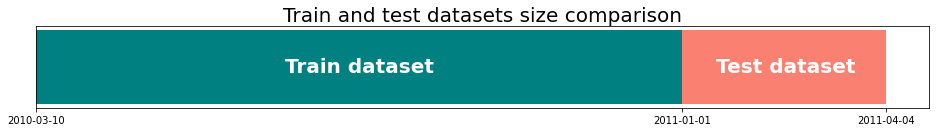

In [9]:
# Plot dataframe
df = pd.concat([train["date_time"], test["date_time"]], axis=0).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(16, 1.5))
bar1 =  ax.barh(0, 7111+2247, color="salmon", height=0.2)
bar2 =  ax.barh(0, 7111, color="teal", height=0.2)
ax.set_title("Train and test datasets size comparison", fontsize=20, pad=5)
ax.bar_label(bar1, ["Test dataset"], label_type="edge", padding=-170,
             fontsize=20, color="white", weight="bold")
ax.bar_label(bar2, ["Train dataset"], label_type="center",
             fontsize=20, color="white", weight="bold")
ax.set_xticks([0, 7111, 7111+2247])
ax.set_xticklabels(["2010-03-10", "2011-01-01", "2011-04-04"])
ax.set_yticks([])
plt.show();

The datasets also have three target columns that the model have to predict. Let's see how each target is changing in time.

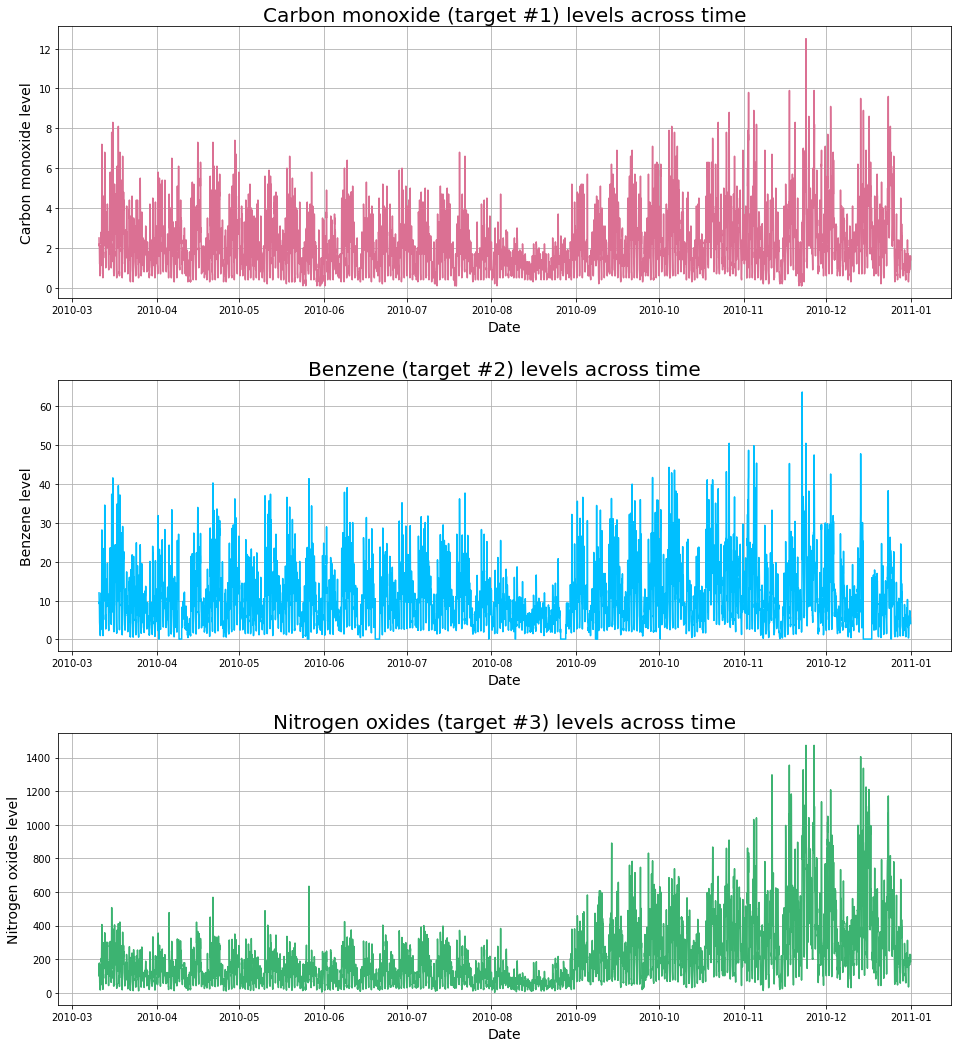

In [10]:
fig, axs = plt.subplots(figsize=(16, 18), ncols=1, nrows=3, sharex=False)

plt.subplots_adjust(hspace = 0.3)

colors = ["palevioletred", "deepskyblue", "mediumseagreen"]

for i in [0, 1, 2]:
    axs[i].plot(train["date_time"], train[targets[i]], color=colors[i])
    axs[i].set_title(f"{target_names[i]} (target #{i+1}) levels across time", fontsize=20, pad=5)
    axs[i].set_ylabel(f"{target_names[i]} level", fontsize=14, labelpad=5)
    axs[i].set_xlabel("Date", fontsize=14, labelpad=5)
    axs[i].grid(axis="both")

plt.show();

Let's see mean target values per day of year.

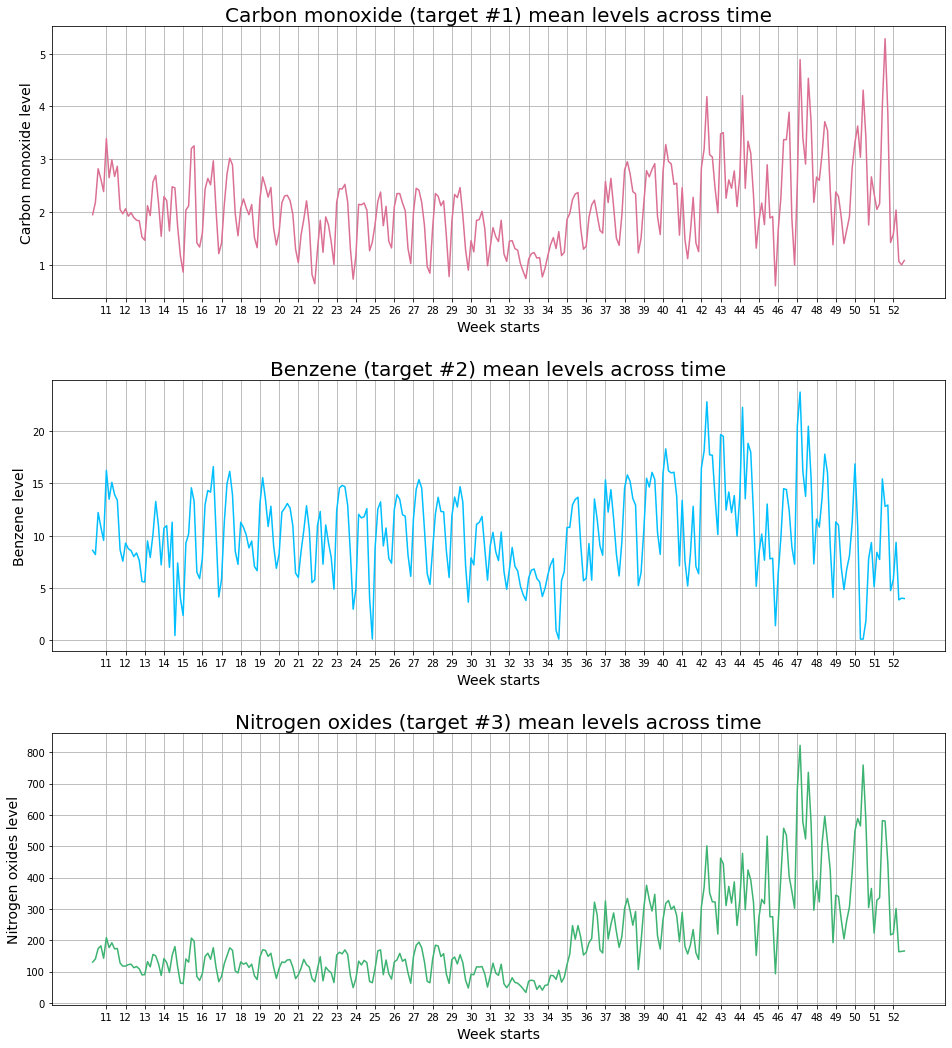

In [11]:
# Dataframe copy excluding the last row which is the only one representing January
df = train.drop([7110], axis=0).copy()
df["day"] = df["date_time"].dt.dayofyear
df["weekday"] = df["date_time"].dt.dayofweek

colors = ["palevioletred", "deepskyblue", "mediumseagreen"]

# An array of number of days of year (i.e. from 1 to 365) which are mondays to mark week starts
mondays = df.loc[df["weekday"] == 0]["day"].value_counts(sort=False).index
# An array of number of weeks of year to be used as label ticks
weeks = df["date_time"].dt.isocalendar().week.unique()[1:]

fig, axs = plt.subplots(figsize=(16, 18), ncols=1, nrows=3, sharex=False)

plt.subplots_adjust(hspace = 0.3)

for i in [0, 1, 2]:
    axs[i].plot(df.groupby("day")[targets[i]].mean().index,
                df.groupby("day")[targets[i]].mean().values, color=colors[i])
    axs[i].set_title(f"{target_names[i]} (target #{i+1}) mean levels across time", fontsize=20, pad=5)
    axs[i].set_ylabel(f"{target_names[i]} level", fontsize=14, labelpad=5)
    axs[i].set_xlabel("Week starts", fontsize=14, labelpad=5)
    axs[i].set_xticks(mondays)
    axs[i].set_xticklabels(weeks)
    axs[i].grid(axis="both")

plt.show();

As you can see, all target values usually go down at the end of each week (i.e. during weekends). 

Let's check targets distribution along each month.

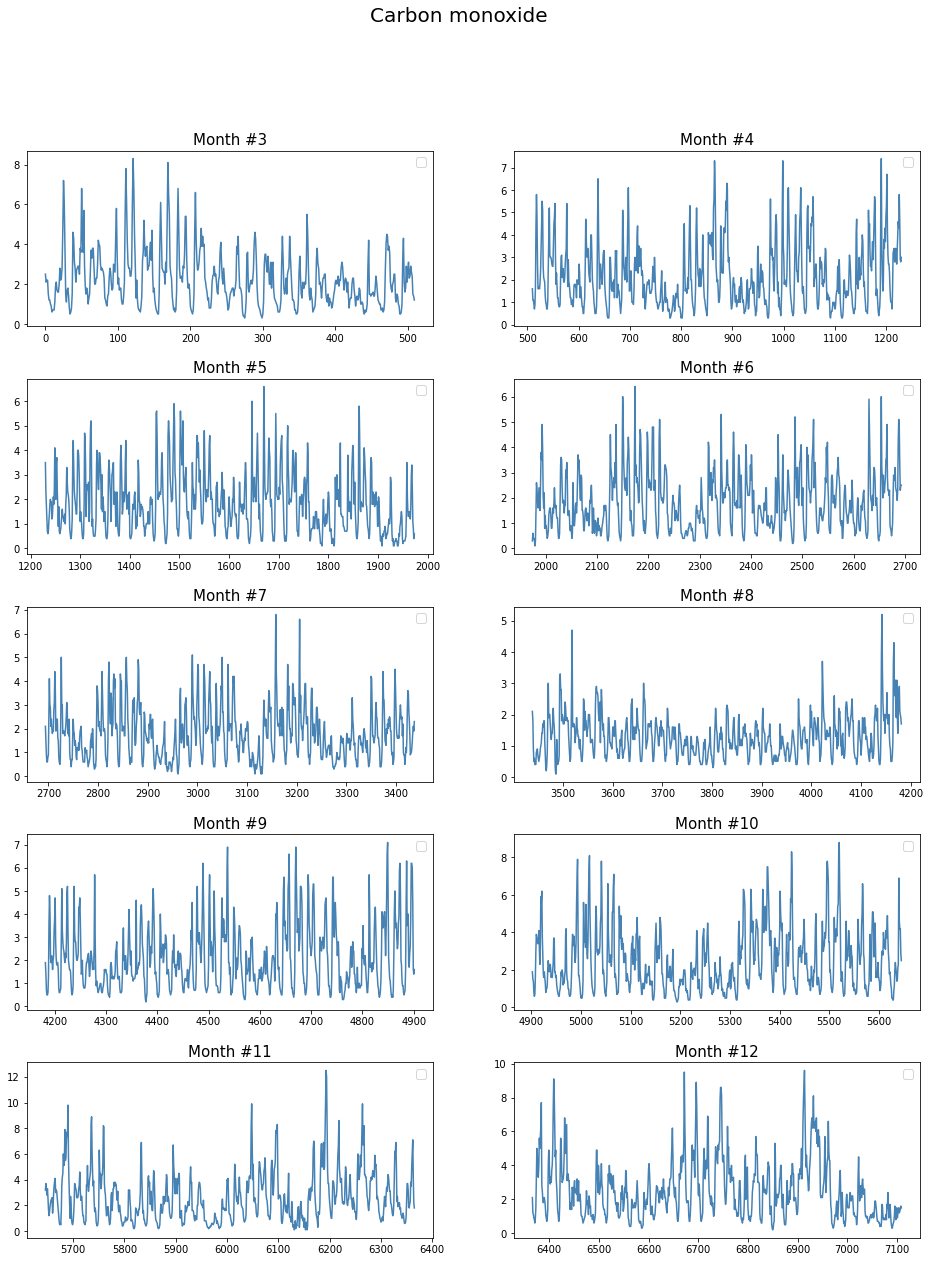

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(16, 20))
plt.subplots_adjust(hspace = 0.3)
fig.suptitle(target_names[0], fontsize=20)

i=3
for r in np.arange(5):
    for c in [0, 1]:
        axs[r, c].plot(train.loc[train["month"]==i, targets[0]], color="steelblue")
        axs[r, c].set_title(f"Month #{i}", fontsize=15)
        axs[r, c].legend(fontsize=13)
        i+=1

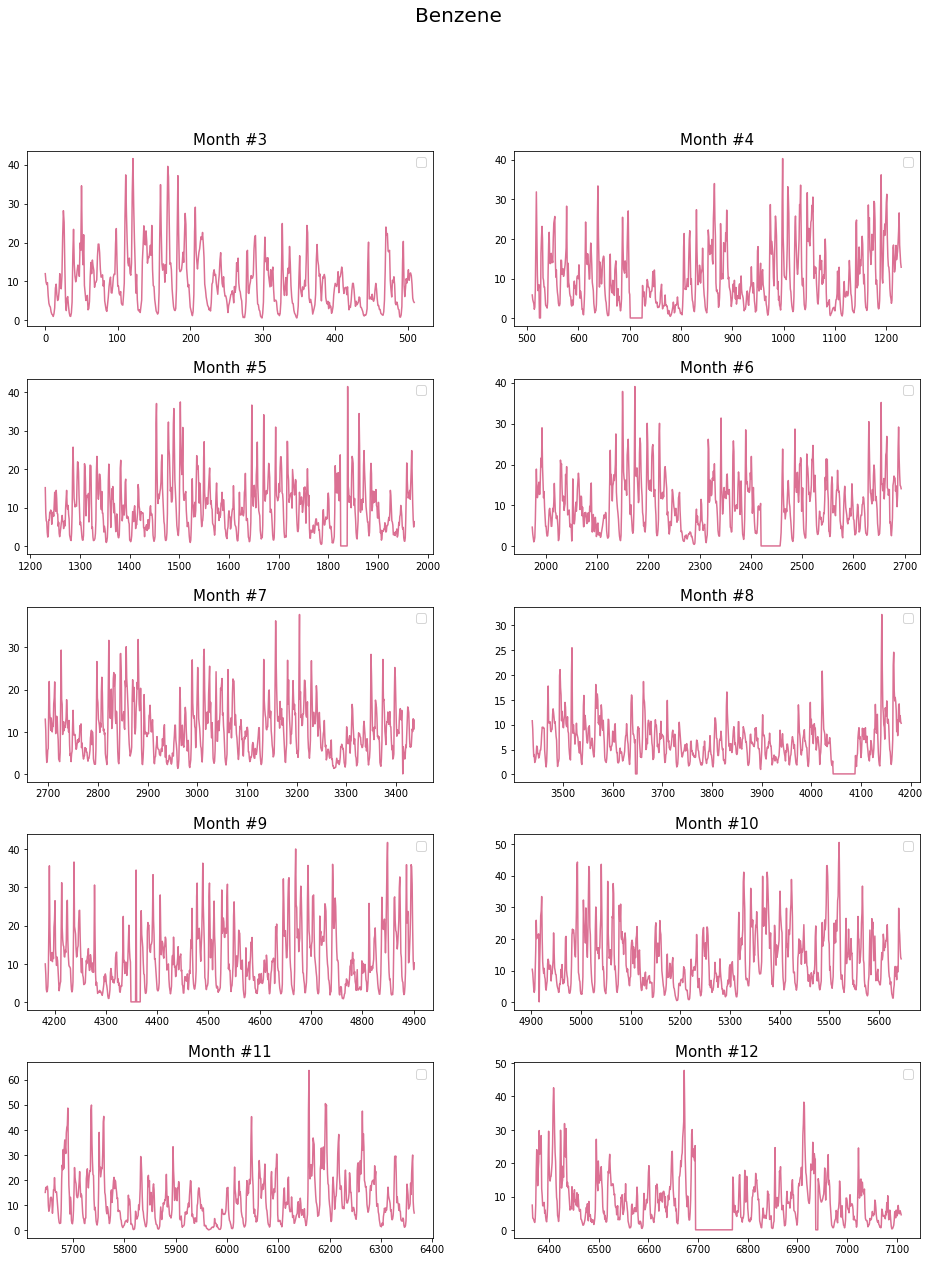

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(16, 20))
plt.subplots_adjust(hspace = 0.3)
fig.suptitle(target_names[1], fontsize=20)

i=3
for r in np.arange(5):
    for c in [0, 1]:
        axs[r, c].plot(train.loc[train["month"]==i, targets[1]], color="palevioletred")
        axs[r, c].set_title(f"Month #{i}", fontsize=15)
        axs[r, c].legend(fontsize=13)
        i+=1

There are some near zer flat areas at 4th, 6th, 8th, 12th month plots. Need to figure out what is so special about these days. It also may be a garbage data which sould be deleted before machine learning.

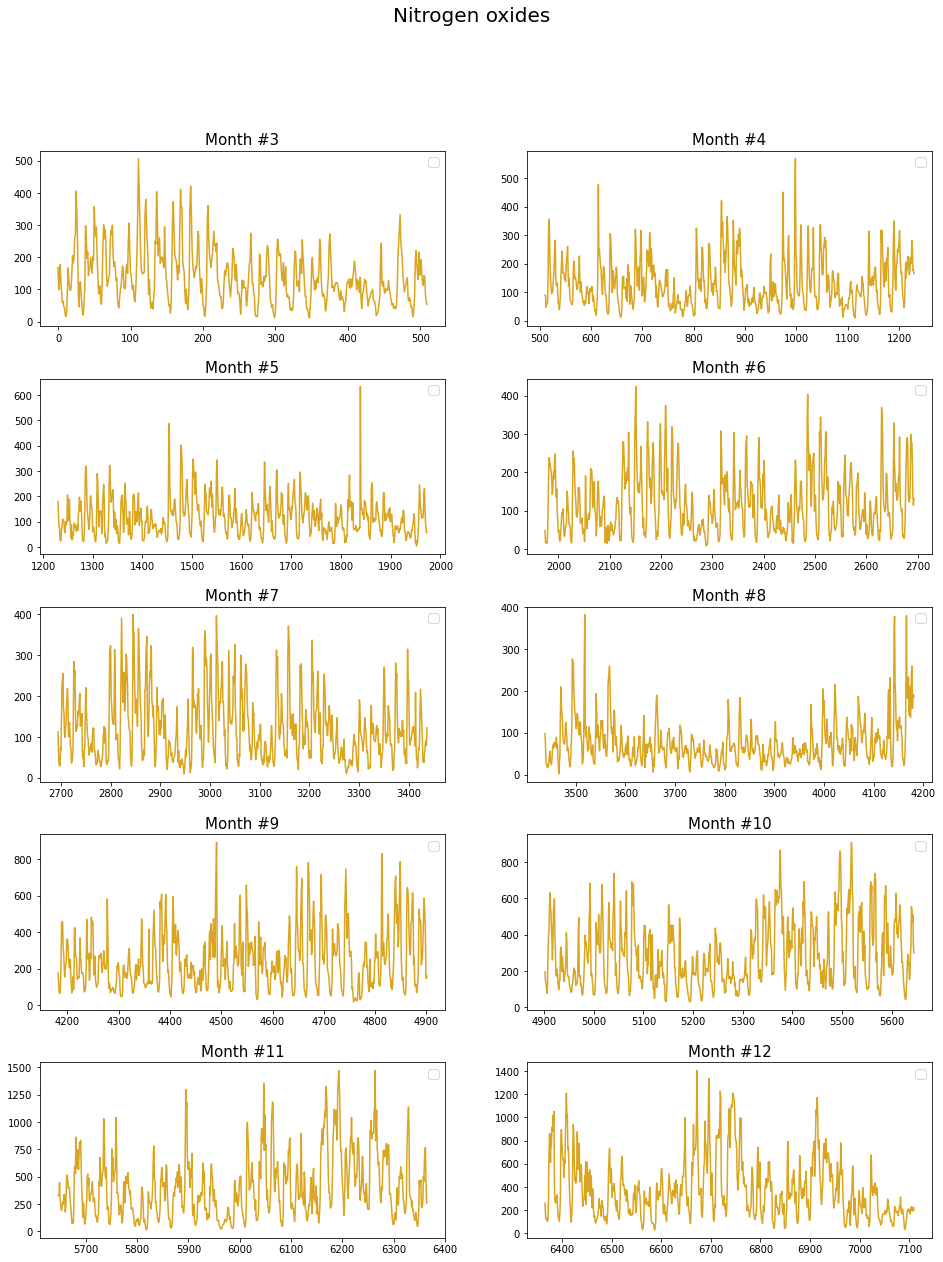

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(16, 20))
plt.set_cmap("Set2")
plt.subplots_adjust(hspace = 0.3)
fig.suptitle(target_names[2], fontsize=20)

i=3
for r in np.arange(5):
    for c in [0, 1]:
        axs[r, c].plot(train.loc[train["month"]==i, targets[2]], color="goldenrod")
        axs[r, c].set_title(f"Month #{i}", fontsize=15)
        axs[r, c].legend(fontsize=13)
        i+=1

Let's check each target value distribution.

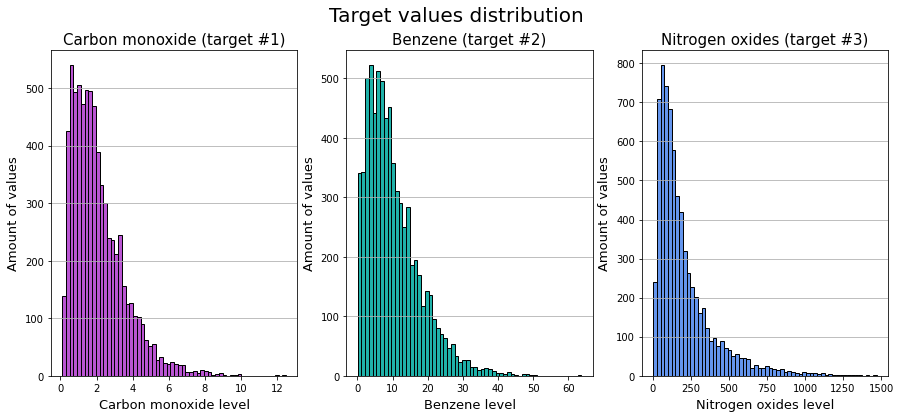

In [15]:
fig, axs = plt.subplots(figsize=(15, 6), ncols=3, nrows=1, sharey=False)

fig.suptitle("Target values distribution", fontsize=20)

colors = ["mediumorchid", "lightseagreen", "cornflowerblue"]

for i in [0, 1, 2]:
    axs[i].hist(train[targets[i]], bins=60, edgecolor="black", color=colors[i])
    axs[i].set_title(f"{target_names[i]} (target #{i+1})", fontsize=15, pad=5)
    axs[i].set_ylabel("Amount of values", fontsize=13, labelpad=5)
    axs[i].set_xlabel(f"{target_names[i]} level", fontsize=13, labelpad=5)
    axs[i].grid(axis="y")

plt.show();

Let's check how each target value chenges depending on the time of day, day of week, and month.

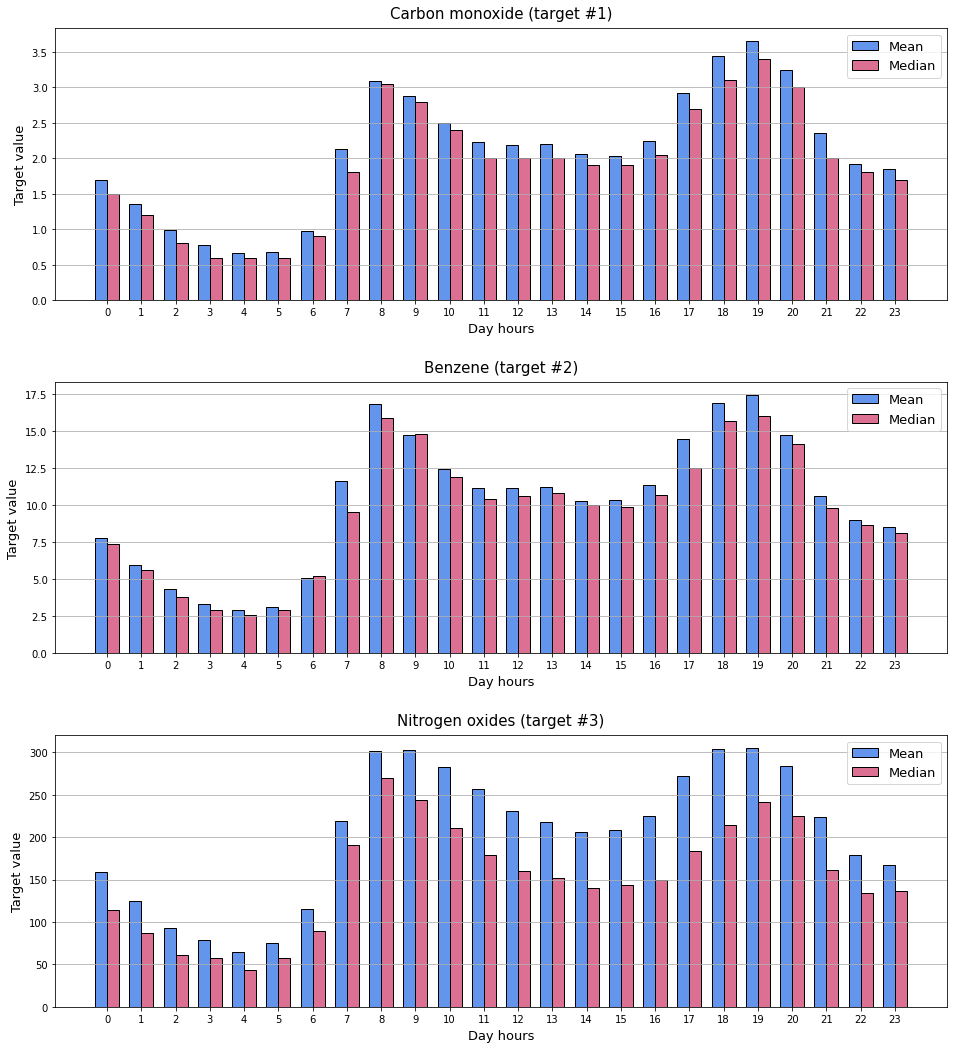

In [16]:
fig, axs = plt.subplots(figsize=(16, 18), ncols=1, nrows=3, sharex=False)

plt.subplots_adjust(hspace = 0.3)
width=0.35
x = train.groupby("hour")["target_carbon_monoxide"].mean().index

for i in np.arange(3):
    bars1 = axs[i].bar(x-width/2, train.groupby("hour")[targets[i]].mean(),
                        width=width, edgecolor="black", label="Mean", color="cornflowerblue")
    bars2 = axs[i].bar(x+width/2, train.groupby("hour")[targets[i]].median(),
                        width=width, edgecolor="black", label="Median", color="palevioletred")
    axs[i].set_title(f"{target_names[i]} (target #{i+1})", fontsize=15, pad=10)
    axs[i].set_ylabel("Target value", fontsize=13, labelpad=5)
    axs[i].set_xlabel("Day hours", fontsize=13, labelpad=5)
    axs[i].set_xticks(x)
    axs[i].grid(axis="y")
    axs[i].legend(fontsize=13)

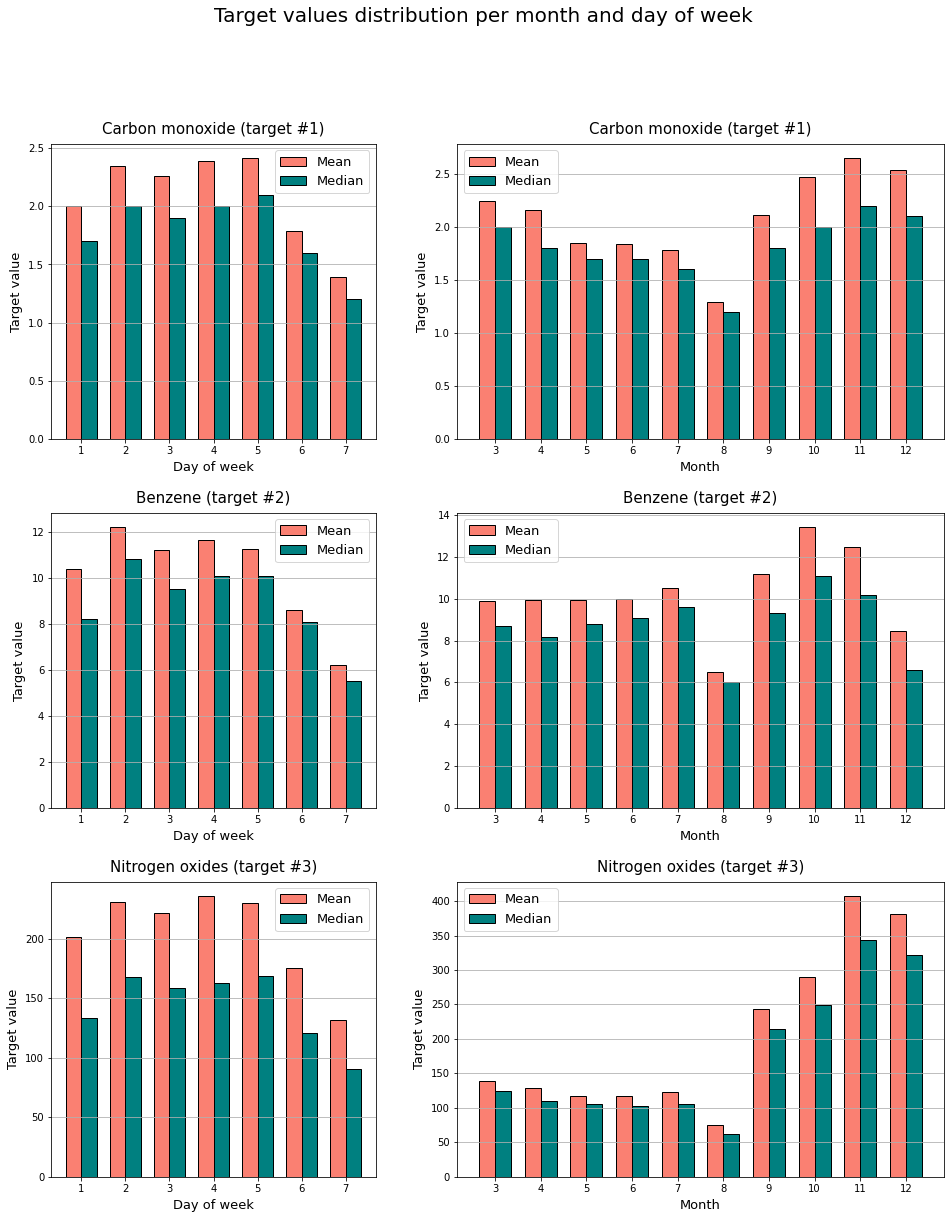

In [17]:
# Dataframe copy excluding the last row which is the only one representing January
df = train.drop([7110], axis=0).copy()

fig, axs = plt.subplots(figsize=(16, 19), ncols=2, nrows=3, sharex=False,
                        gridspec_kw={'width_ratios': [1, 1.5]})

fig.suptitle("Target values distribution per month and day of week", fontsize=20)

plt.subplots_adjust(hspace = 0.25)
width=0.35
x = df.groupby("day_of_week")["target_carbon_monoxide"].mean().index + 1

for i in np.arange(3):
    bars1 = axs[i, 0].bar(x-width/2, df.groupby("day_of_week")[targets[i]].mean(),
                        width=width, edgecolor="black", label="Mean", color="salmon")
    bars2 = axs[i, 0].bar(x+width/2, df.groupby("day_of_week")[targets[i]].median(),
                        width=width, edgecolor="black", label="Median", color="teal")
    axs[i, 0].set_title(f"{target_names[i]} (target #{i+1})", fontsize=15, pad=10)
    axs[i, 0].set_ylabel("Target value", fontsize=13, labelpad=5)
    axs[i, 0].set_xlabel("Day of week", fontsize=13, labelpad=5)
    axs[i, 0].set_xticks(x)
    axs[i, 0].grid(axis="y")
    axs[i, 0].legend(fontsize=13)

x = df.groupby("month")["target_carbon_monoxide"].mean().index
for i in np.arange(3):
    bars1 = axs[i, 1].bar(x-width/2, df.groupby("month")[targets[i]].mean(),
                        width=width, edgecolor="black", label="Mean", color="salmon")
    bars2 = axs[i, 1].bar(x+width/2, df.groupby("month")[targets[i]].median(),
                        width=width, edgecolor="black", label="Median", color="teal")
    axs[i, 1].set_title(f"{target_names[i]} (target #{i+1})", fontsize=15, pad=10)
    axs[i, 1].set_ylabel("Target value", fontsize=13, labelpad=5)
    axs[i, 1].set_xlabel("Month", fontsize=13, labelpad=5)
    axs[i, 1].set_xticks(x)
    axs[i, 1].grid(axis="y")
    axs[i, 1].legend(fontsize=13)

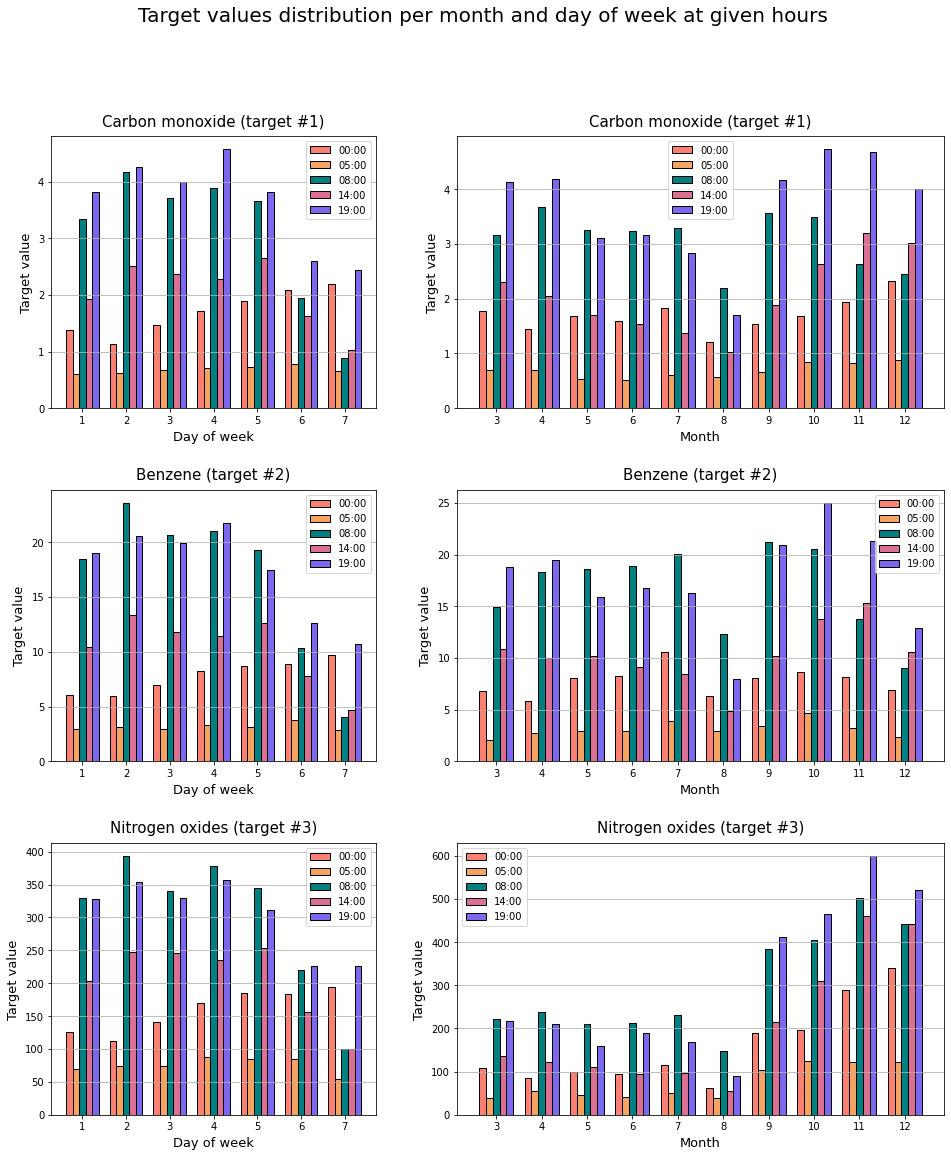

In [18]:
# Day hours which will be used for plotting data
hours = [0, 5, 8, 14, 19]
# Dataframe copy excluding the last row which is the only one representing January
df = train.loc[train["hour"].isin(hours)].drop([7110], axis=0).copy()

fig, axs = plt.subplots(figsize=(16, 18), ncols=2, nrows=3, sharex=False,
                        gridspec_kw={'width_ratios': [1, 1.5]})

fig.suptitle("Target values distribution per month and day of week at given hours", fontsize=20)

plt.subplots_adjust(hspace = 0.3)
width=0.15
x = np.sort(df["day_of_week"].unique()) + 1

for i in np.arange(3):
    bars1 = axs[i, 0].bar(x-width*2, df.loc[df["hour"] == 0].groupby("day_of_week")[targets[i]].mean(),
                        width=width, edgecolor="black", label="00:00", color="salmon")
    bars2 = axs[i, 0].bar(x-width, df.loc[df["hour"] == 5].groupby("day_of_week")[targets[i]].mean(),
                        width=width, edgecolor="black", label="05:00", color="sandybrown")
    bars3 = axs[i, 0].bar(x, df.loc[df["hour"] == 8].groupby("day_of_week")[targets[i]].mean(),
                        width=width, edgecolor="black", label="08:00", color="teal")
    bars4 = axs[i, 0].bar(x+width, df.loc[df["hour"] == 14].groupby("day_of_week")[targets[i]].mean(),
                        width=width, edgecolor="black", label="14:00", color="palevioletred")
    bars5 = axs[i, 0].bar(x+width*2, df.loc[df["hour"] == 19].groupby("day_of_week")[targets[i]].mean(),
                        width=width, edgecolor="black", label="19:00", color="mediumslateblue")
    axs[i, 0].set_title(f"{target_names[i]} (target #{i+1})", fontsize=15, pad=10)
    axs[i, 0].set_ylabel("Target value", fontsize=13, labelpad=5)
    axs[i, 0].set_xlabel("Day of week", fontsize=13, labelpad=5)
    axs[i, 0].set_xticks(x)
    axs[i, 0].grid(axis="y")
    axs[i, 0].legend(fontsize=10)

x = df["month"].unique()
for i in np.arange(3):
    bars1 = axs[i, 1].bar(x-width*2, df.loc[df["hour"] == 0].groupby("month")[targets[i]].mean(),
                        width=width, edgecolor="black", label="00:00", color="salmon")
    bars2 = axs[i, 1].bar(x-width, df.loc[df["hour"] == 5].groupby("month")[targets[i]].mean(),
                        width=width, edgecolor="black", label="05:00", color="sandybrown")
    bars3 = axs[i, 1].bar(x, df.loc[df["hour"] == 8].groupby("month")[targets[i]].mean(),
                        width=width, edgecolor="black", label="08:00", color="teal")
    bars4 = axs[i, 1].bar(x+width, df.loc[df["hour"] == 14].groupby("month")[targets[i]].mean(),
                        width=width, edgecolor="black", label="14:00", color="palevioletred")
    bars5 = axs[i, 1].bar(x+width*2, df.loc[df["hour"] == 19].groupby("month")[targets[i]].mean(),
                        width=width, edgecolor="black", label="19:00", color="mediumslateblue")
    axs[i, 1].set_title(f"{target_names[i]} (target #{i+1})", fontsize=15, pad=10)
    axs[i, 1].set_ylabel("Target value", fontsize=13, labelpad=5)
    axs[i, 1].set_xlabel("Month", fontsize=13, labelpad=5)
    axs[i, 1].set_xticks(x)
    axs[i, 1].grid(axis="y")
    axs[i, 1].legend(fontsize=10)

## Feature plots

In [19]:
# Lists of feature names to be used for plots below
all_features = ["deg_C", "relative_humidity", "absolute_humidity", "sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5"]
all_feature_names = ["Temperature (deg. C)", "Relative humidity", "Absolute humidity", "Sensor 1", "Sensor_2", "Sensor 3", "Sensor 4", "Sensor 5"]

weather_features = ["deg_C", "relative_humidity", "absolute_humidity"]
weather_feature_names = ["Temperature (deg. C)", "Relative humidity", "Absolute humidity"]

sensor_features = ["sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5"]
sensor_feature_names = ["Sensor 1", "Sensor_2", "Sensor 3", "Sensor 4", "Sensor 5"]

Let's compare our train and test feature data.

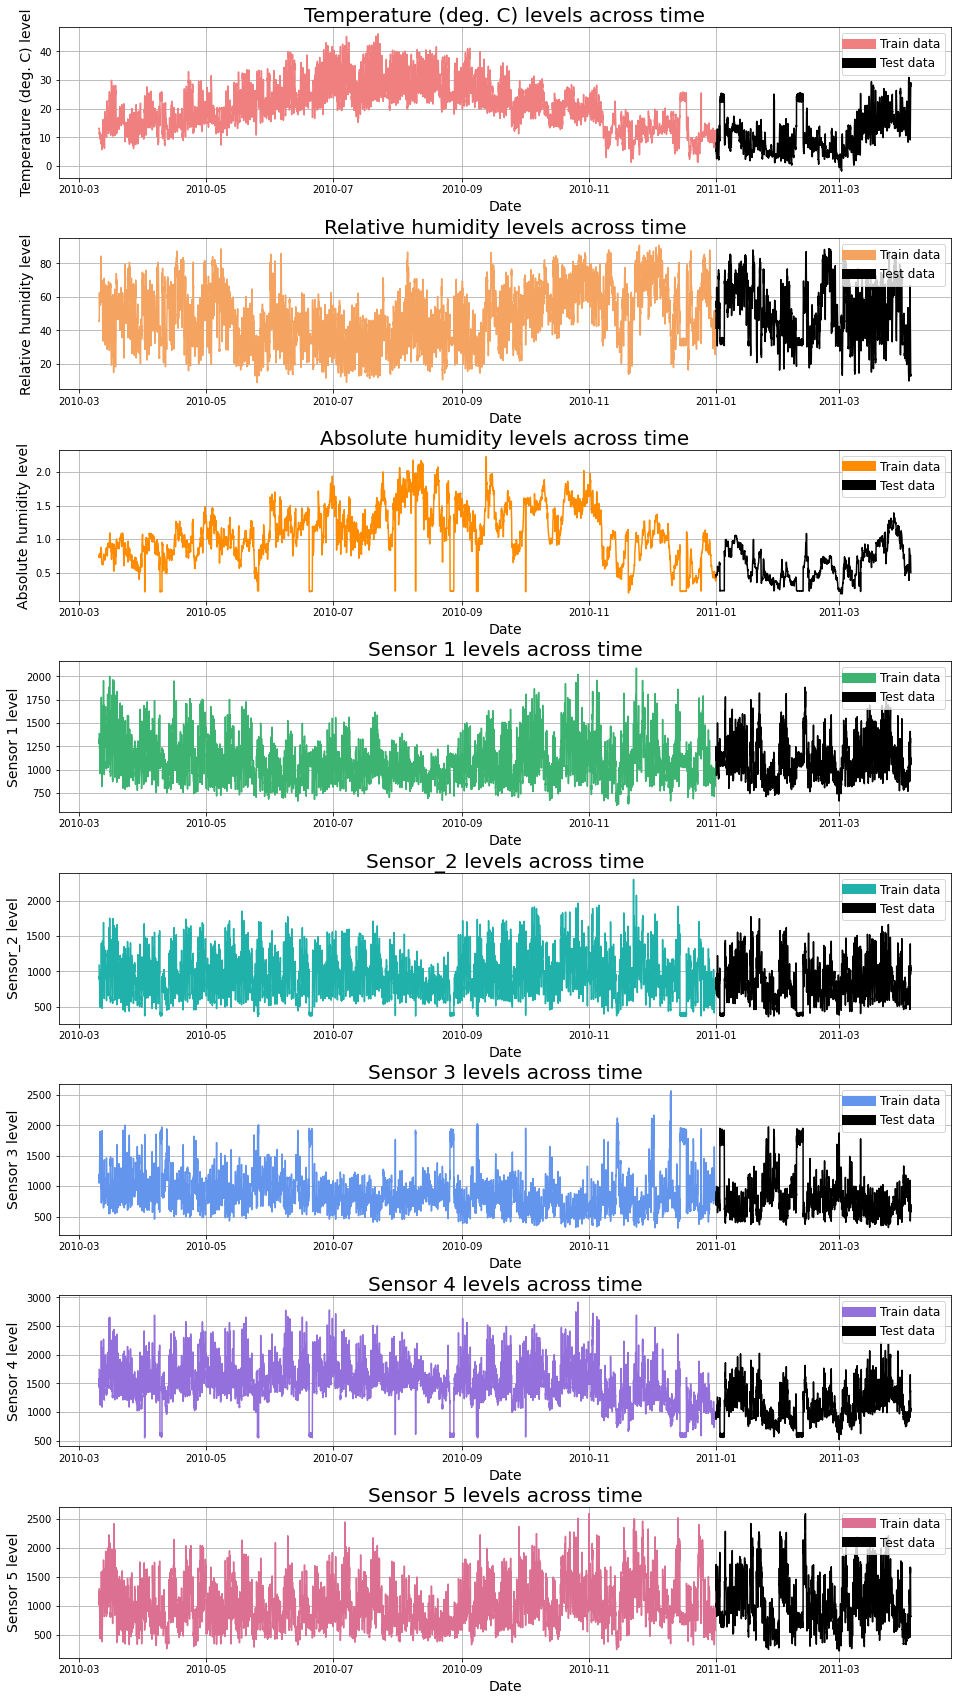

In [20]:
fig, axs = plt.subplots(figsize=(16, 30), ncols=1, nrows=8, sharex=False)

plt.subplots_adjust(hspace = 0.4)

colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]

for i in np.arange(8):
    legend_lines = [Line2D([0], [0], color=colors[i], lw=10),
                    Line2D([0], [0], color="black", lw=10)]
    axs[i].plot(train["date_time"], train[all_features[i]], color=colors[i], label="Train data")
    axs[i].plot(test["date_time"], test[all_features[i]], color="black", label="Test data")
    axs[i].set_title(f"{all_feature_names[i]} levels across time", fontsize=20, pad=5)
    axs[i].set_ylabel(f"{all_feature_names[i]} level", fontsize=14, labelpad=5)
    axs[i].set_xlabel("Date", fontsize=14, labelpad=5)
    axs[i].legend(legend_lines, ["Train data", "Test data"], fontsize=12, loc=1)
    axs[i].grid(axis="both")

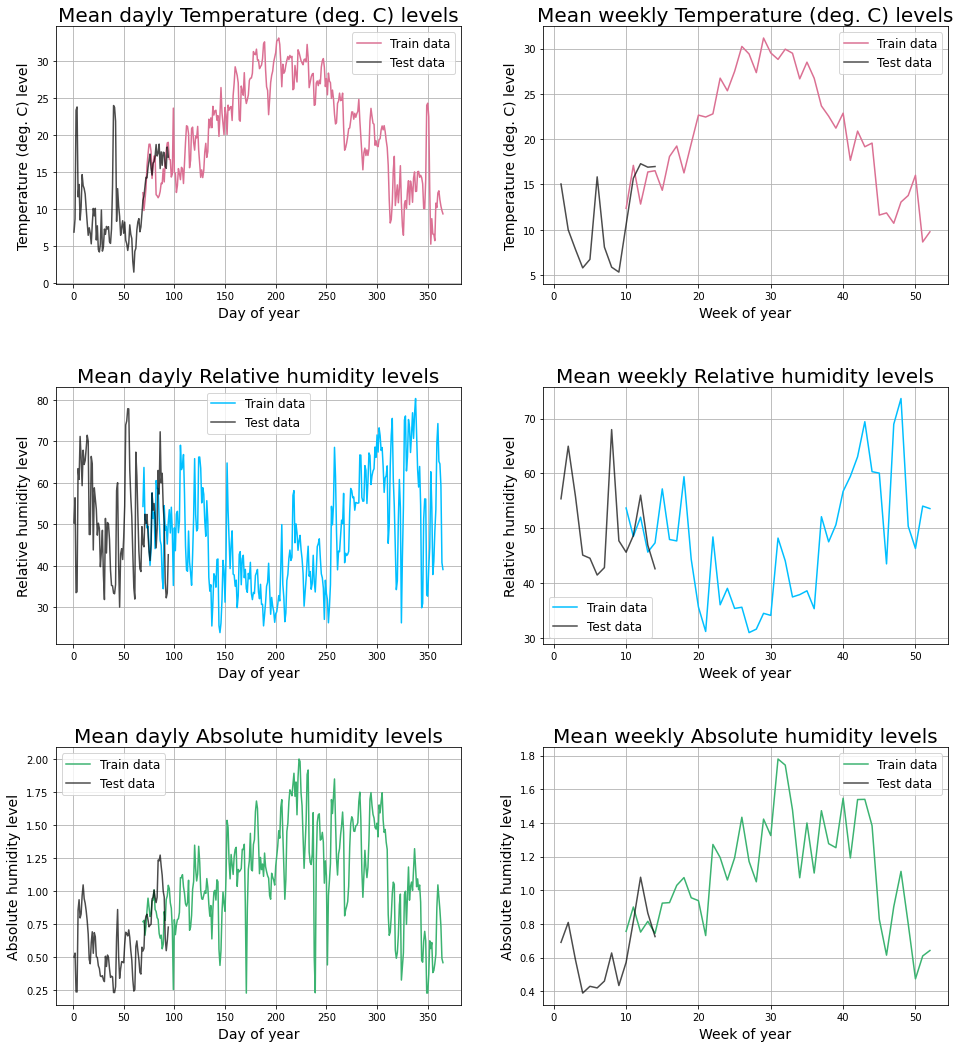

In [21]:
# Plot dataframe creation
df = pd.concat([train_copy, test_copy], axis=0)
df.reset_index(drop=True, inplace=True)
df["week_of_year"] = df["date_time"].dt.isocalendar().week.astype("int")
df["day_of_year"] = df["date_time"].dt.dayofyear

fig, axs = plt.subplots(figsize=(16, 18), ncols=2, nrows=3, sharex=False)

plt.subplots_adjust(hspace = 0.4)

colors = ["palevioletred", "deepskyblue", "mediumseagreen"]

for i in [0, 1, 2]:
    # New year days start from 7110th row
    data = df.iloc[:7110].groupby("day_of_year")[weather_features[i]].mean()
    axs[i, 0].plot(data.index, data.values, color=colors[i], label="Train data")
    data = df.iloc[7110:].groupby("day_of_year")[weather_features[i]].mean()
    axs[i, 0].plot(data.index, data.values, color="black", alpha=0.7, label="Test data")
    axs[i, 0].set_title(f"Mean dayly {weather_feature_names[i]} levels", fontsize=20, pad=5)
    axs[i, 0].set_ylabel(f"{weather_feature_names[i]} level", fontsize=14, labelpad=5)
    axs[i, 0].set_xlabel("Day of year", fontsize=14, labelpad=5)
    axs[i, 0].grid(axis="both")
    axs[i, 0].legend(fontsize=12)


for i in [0, 1, 2]:
    # New year weeks start from 7159th row. 
    # Because of Jan 1st and 2nd from the test dataset are counted as 52nd week of 2010,
    # the colored plotline contains some test data. 
    data = df.iloc[:7159].groupby("week_of_year")[weather_features[i]].mean()
    axs[i, 1].plot(data.index, data.values, color=colors[i], label="Train data")
    data = df.iloc[7159:].groupby("week_of_year")[weather_features[i]].mean()
    axs[i, 1].plot(data.index, data.values, color="black", alpha=0.7, label="Test data")
    axs[i, 1].set_title(f"Mean weekly {weather_feature_names[i]} levels", fontsize=20, pad=5)
    axs[i, 1].set_ylabel(f"{weather_feature_names[i]} level", fontsize=14, labelpad=5)
    axs[i, 1].set_xlabel("Week of year", fontsize=14, labelpad=5)
    axs[i, 1].grid(axis="both")
    axs[i, 1].legend(fontsize=12)

plt.show();

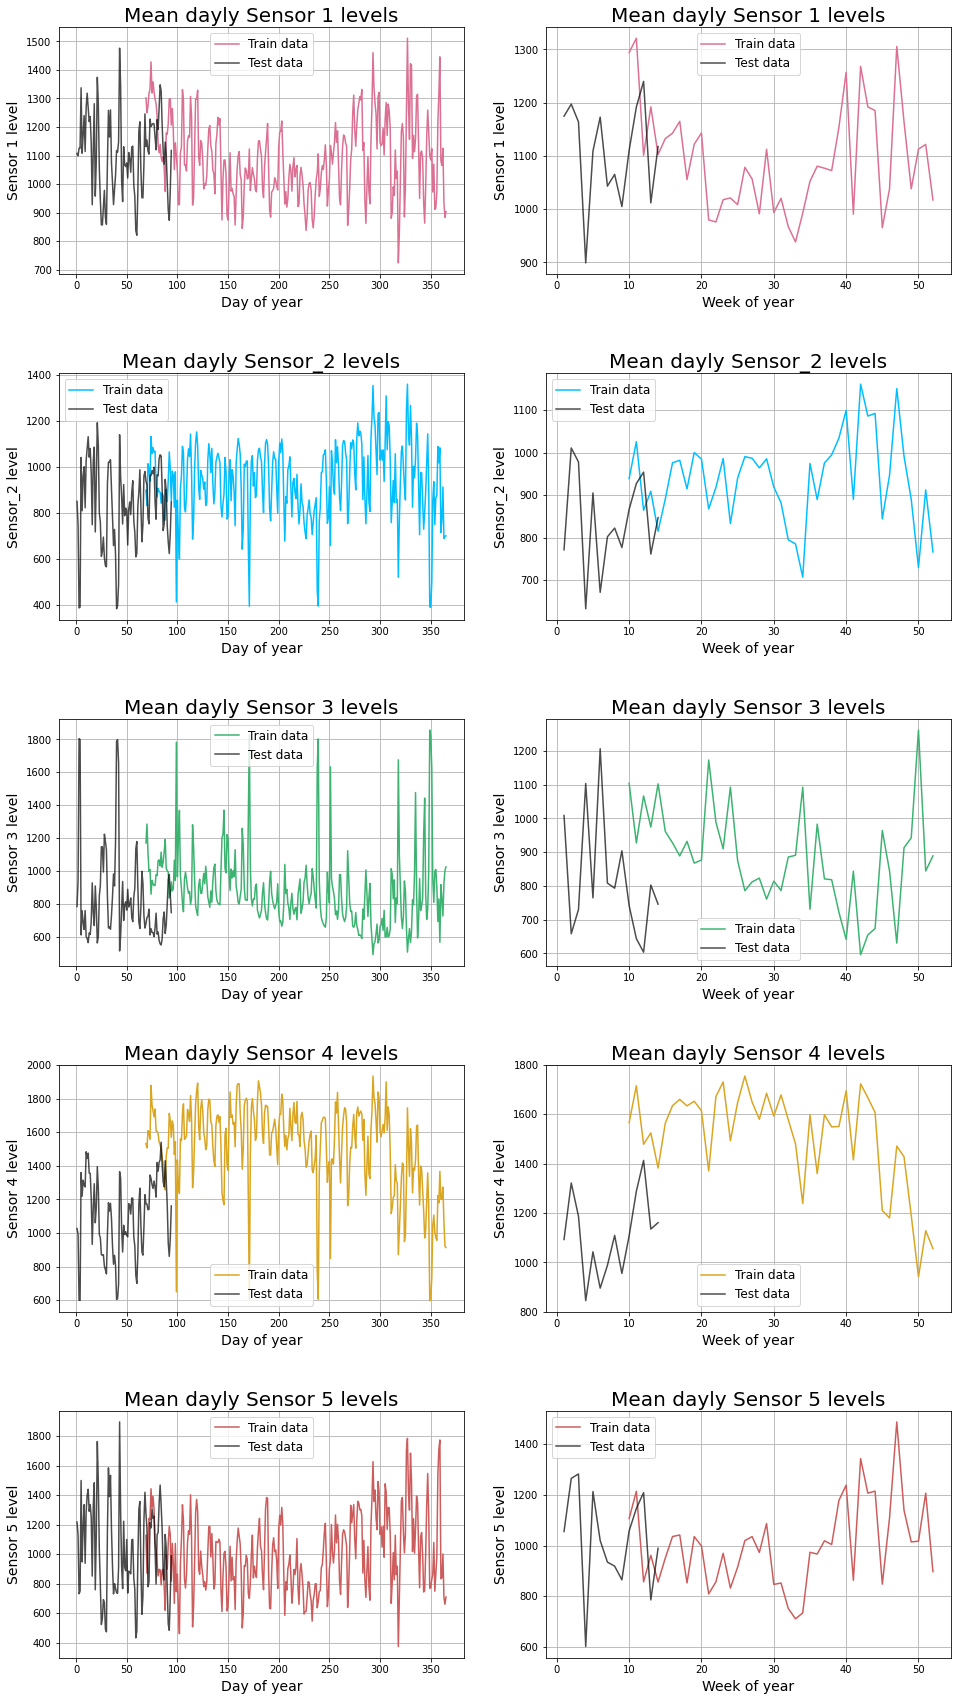

In [22]:
# Plot dataframe creation
df = pd.concat([train_copy, test_copy], axis=0)
df.reset_index(drop=True, inplace=True)
df["week_of_year"] = df["date_time"].dt.isocalendar().week.astype("int")
df["day_of_year"] = df["date_time"].dt.dayofyear

fig, axs = plt.subplots(figsize=(16, 30), ncols=2, nrows=5, sharex=False)

plt.subplots_adjust(hspace = 0.4)

colors = ["palevioletred", "deepskyblue", "mediumseagreen", "goldenrod", "indianred"]

for i in np.arange(5):
    data = df.iloc[:7110].groupby("day_of_year")[sensor_features[i]].mean()
    axs[i, 0].plot(data.index, data.values, color=colors[i], label="Train data")
    data = df.iloc[7110:].groupby("day_of_year")[sensor_features[i]].mean()
    axs[i, 0].plot(data.index, data.values, color="black", alpha=0.7, label="Test data")
    axs[i, 0].set_title(f"Mean dayly {sensor_feature_names[i]} levels", fontsize=20, pad=5)
    axs[i, 0].set_ylabel(f"{sensor_feature_names[i]} level", fontsize=14, labelpad=5)
    axs[i, 0].set_xlabel("Day of year", fontsize=14, labelpad=5)
    axs[i, 0].grid(axis="both")
    axs[i, 0].legend(fontsize=12)


for i in np.arange(5):
    data = df.iloc[:7159].groupby("week_of_year")[sensor_features[i]].mean()
    axs[i, 1].plot(data.index, data.values, color=colors[i], label="Train data")
    data = df.iloc[7159:].groupby("week_of_year")[sensor_features[i]].mean()
    axs[i, 1].plot(data.index, data.values, color="black", alpha=0.7, label="Test data")
    axs[i, 1].set_title(f"Mean dayly {sensor_feature_names[i]} levels", fontsize=20, pad=5)
    axs[i, 1].set_ylabel(f"{sensor_feature_names[i]} level", fontsize=14, labelpad=5)
    axs[i, 1].set_xlabel("Week of year", fontsize=14, labelpad=5)
    axs[i, 1].grid(axis="both")
    axs[i, 1].legend(fontsize=12)

plt.show();

Let's check feature correlation.

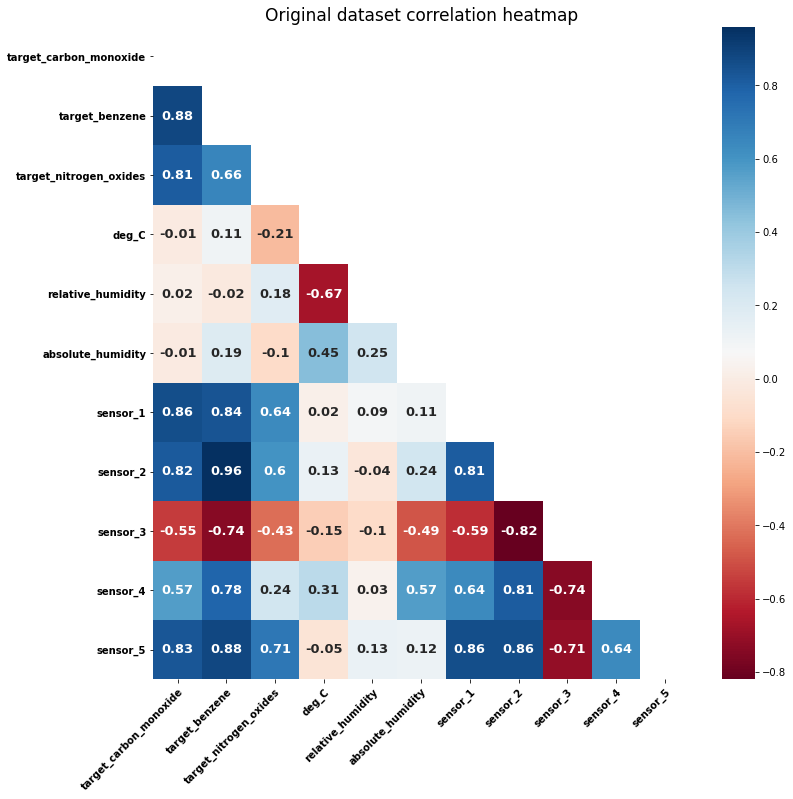

In [23]:
# Plot dataframe
df = train_copy.copy()
df = pd.concat([df[targets], df.drop(targets, axis=1)], axis=1).corr().round(2)

# Mask to hide upper-right part of plot as it is a duplicate
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(12,12))
ax = sns.heatmap(df, annot=True, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})
ax.set_title("Original dataset correlation heatmap", fontsize=17)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", weight="bold")
plt.setp(ax.get_yticklabels(), weight="bold")
plt.show();

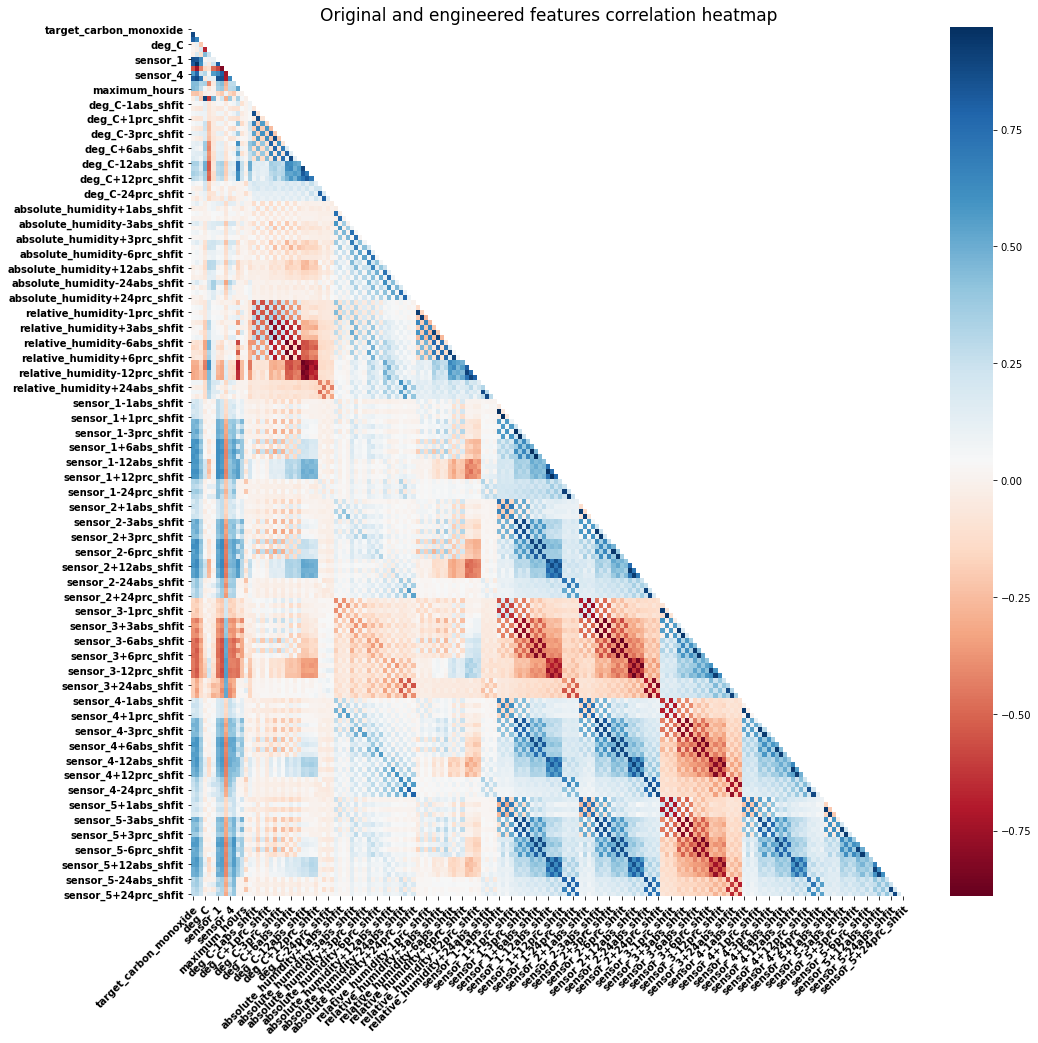

In [24]:
# Plot dataframe
df = add_new_ml_features(train_copy.copy())
df = pd.concat([df[targets], df.drop(targets, axis=1)], axis=1).corr().round(2)

# Mask to hide upper-right part of plot as it is a duplicate
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(16,16))
ax = sns.heatmap(df, annot=False, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize": 7})
ax.set_title("Original and engineered features correlation heatmap", fontsize=17)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", weight="bold")
plt.setp(ax.get_yticklabels(), weight="bold")
plt.show();

# **Model training**

In [25]:
# # Dropping rows detected as anomalies
# X = train_copy.drop(to_drop, axis=0)
X = add_new_ml_features(train_copy.copy())

# Dropping the last row which is 2011-01-01 00:00:00
if X.index[-1] == 7110:
    X.drop([7110], axis=0, inplace=True)

# Resetting dataframe index
X.reset_index(drop=True, inplace=True)

# The months will be used for folds split
months = X["date_time"].dt.month

# Initializing and filling predictions dataframe before datetime conversion
preds = pd.DataFrame()
preds["date_time"] = test_copy["date_time"].copy()

# Adding 23 last train set rows to the head of test set in order to get shifting feature values
X_test_temp = pd.concat([train_copy.iloc[-25:-1].drop(["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"], axis=1), test_copy], axis=0)
X_test_temp.reset_index(inplace=True, drop=True)
X_test = add_new_ml_features(X_test_temp.copy())
# Deleting added train set rows
X_test.drop(X_test.loc[:23].index, axis=0, inplace=True)
X_test.reset_index(inplace=True, drop=True)

y = np.log1p(X[["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"]])
X.drop(["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"], axis=1, inplace=True)

The datetime conversion shown below was found in this [notebook](https://www.kaggle.com/jarupula/eda-rf-model-tps-july-21). It gives a significant score boost.

In [26]:
X['date_time'] = X['date_time'].astype('datetime64[ns]').astype(np.int64)/10**9
X_test['date_time'] = X_test['date_time'].astype('datetime64[ns]').astype(np.int64)/10**9

In [27]:
print(X.shape, y.shape, X_test.shape)
display(X)
display(y)

(7110, 173) (7110, 3) (2247, 173)


date_time    deg_C  relative_humidity  absolute_humidity  \
0    1268244000.00000 13.10000           46.00000            0.75780   
1    1268247600.00000 13.20000           45.30000            0.72550   
2    1268251200.00000 12.60000           56.20000            0.75020   
3    1268254800.00000 11.00000           62.40000            0.78670   
4    1268258400.00000 11.90000           59.00000            0.78880   
...               ...      ...                ...                ...   
7105 1293822000.00000  9.10000           34.30000            0.39580   
7106 1293825600.00000  9.20000           32.00000            0.38710   
7107 1293829200.00000  9.10000           33.20000            0.37660   
7108 1293832800.00000  9.60000           34.60000            0.43100   
7109 1293836400.00000  8.00000           40.70000            0.40850   

       sensor_1   sensor_2   sensor_3   sensor_4   sensor_5  working_hours  \
0    1387.20000 1087.80000 1056.00000 1742.80000 1293.40000              1   
1    1279.10000  888.20000 1197.50000 1449.90000 1010.90000              1   
2    1331.90000  929.60000 1060.20000 1586.10000 1117.00000              1   
3    1321.00000  929.00000 1102.90000 1536.50000 1263.20000              0   
4    1272.00000  852.70000 1180.90000 1415.50000 1132.20000              0   
...         ...        ...        ...        ...        ...            ...   
7105  957.90000  741.90000  970.30000  915.10000  866.00000              1   
7106 1000.50000  811.20000  873.00000  909.00000  910.50000              1   
7107 1022.70000  790.00000  951.60000  912.90000  903.40000              0   
7108 1044.40000  767.30000  861.90000  889.20000 1159.10000              0   
7109  952.80000  691.90000  908.50000  917.00000 1206.30000              0   

      maximum_hours  is_weekend     SMC  deg_C-1abs_shfit  deg_C+1abs_shfit  \
0                 1           0 1.64739          13.10000          -0.10000   
1                 1           0 1.60155           0.10000           0.60000   
2                 1           0 1.33488          -0.60000           1.60000   
3                 0           0 1.26074          -1.60000          -0.90000   
4                 0           0 1.33695           0.90000           0.70000   
...             ...         ...     ...               ...               ...   
7105              1           0 1.15394          -1.10000          -0.10000   
7106              1           0 1.20969           0.10000           0.10000   
7107              0           0 1.13434          -0.10000          -0.50000   
7108              0           0 1.24566           0.50000           1.60000   
7109              0           0 1.00369          -1.60000           0.00000   

      deg_C-1prc_shfit  deg_C+1prc_shfit  deg_C-3abs_shfit  deg_C+3abs_shfit  \
0              0.00000          -0.00758          13.10000           2.10000   
1              0.00763           0.04762          13.20000           1.30000   
2             -0.04545           0.14545          12.60000           1.40000   
3             -0.12698          -0.07563          -2.10000           0.30000   
4              0.08182           0.06250          -1.30000           1.60000   
...                ...               ...               ...               ...   
7105          -0.10784          -0.01087          -3.30000          -0.50000   
7106           0.01099           0.01099          -2.90000           1.20000   
7107          -0.01087          -0.05208          -1.10000           1.10000   
7108           0.05495           0.20000           0.50000           9.60000   
7109          -0.16667           0.00000          -1.20000           8.00000   

      deg_C-3prc_shfit  deg_C+3prc_shfit  deg_C-6abs_shfit  deg_C+6abs_shfit  \
0              0.00000           0.19091          13.10000           2.40000   
1              0.00000           0.10924          13.20000           2.90000   
2              0.00000           0.12500          12.60000  

target_carbon_monoxide  target_benzene  target_nitrogen_oxides
0                    1.25276         2.56495                 5.12812
1                    1.13140         2.38876                 4.60417
2                    1.16315         2.32239                 4.85281
3                    1.16315         2.37024                 5.18291
4                    0.91629         2.00148                 4.81056
...                      ...             ...                     ...
7105                 0.78846         1.77495                 5.35659
7106                 0.83291         1.80829                 5.25802
7107                 0.87547         1.91692                 5.40403
7108                 0.95551         1.82455                 5.43110
7109                 0.91629         1.72277                 5.30231

[7110 rows x 3 columns]

In [28]:
%%time

# LightAutoML parameters
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 2.9 * 3600 # Time in seconds for automl run

# Fixing parameters for better repeatability 
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

feature_importances = []
for target in y.columns:
    model = TabularUtilizedAutoML(task = Task("reg", loss="rmsle", metric="rmsle"),
                                  verbose=1,
                                  timeout = TIMEOUT,
                                  cpu_limit = N_THREADS,
                                  reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                                  general_params = {'use_algos': [['lgb_tuned', 'cb_tuned'], ['lgb']]}
#                                   general_params = {'use_algos': [['lgb']]}
                                 )

    oof_preds = model.fit_predict(pd.concat([X, y[target]], axis=1), roles = {"target": target})
    print(f"{target} oof_score score is {np.sqrt(mean_squared_log_error(np.expm1(y[target].values), np.expm1(oof_preds.data)))}")
    preds[target] = np.expm1(model.predict(X_test).data)
    feature_importances.append(model.get_feature_scores('fast', silent=False))

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
Time limit exceeded after calculating fold 0
Time limit exceeded in one of the tasks. AutoML will blend level 1 models.


target_carbon_monoxide oof_score score is 0.09299376822050115
target_benzene oof_score score is 0.07643131617472877
target_nitrogen_oxides oof_score score is 0.194725593834455
CPU times: user 1d 5h 17min 53s, sys: 40min 33s, total: 1d 5h 58min 26s
Wall time: 7h 59min 9s


# **Feature importances**

In [29]:
# Creating a sorted dataframe with all feature importances
fi_df = pd.DataFrame(columns=["Feature", "Imp1", "Imp2", "Imp3"])
fi_df["Feature"] = X.columns
fi_df.sort_values("Feature", inplace=True)
fi_df.reset_index(drop=True, inplace=True)
for i, fi in enumerate(feature_importances):
    fi.sort_values("Feature", inplace=True)
    fi.reset_index(drop=True, inplace=True)
    fi_df[("Imp"+str(i+1))] = fi["Importance"] / fi["Importance"].sum()
fi_df["Overall_importance"] = fi_df["Imp1"] + fi_df["Imp2"] + fi_df["Imp3"]
fi_df.sort_values("Overall_importance", ascending=False, inplace=True)
fi_df.reset_index(drop=True, inplace=True)
fi_df

Feature    Imp1    Imp2    Imp3  Overall_importance
0                        sensor_2 0.66426 0.90791 0.17333             1.74551
1                        sensor_5 0.02736 0.01540 0.41236             0.45512
2                       date_time 0.02456 0.00036 0.24063             0.26555
3                        sensor_1 0.17595 0.00265 0.04518             0.22378
4                        sensor_3 0.00441 0.04643 0.00394             0.05478
..                            ...     ...     ...     ...                 ...
168  relative_humidity+1prc_shfit 0.00014 0.00003 0.00016             0.00033
169           sensor_4-1prc_shfit 0.00014 0.00003 0.00015             0.00032
170  relative_humidity-3prc_shfit 0.00014 0.00003 0.00014             0.00032
171  relative_humidity+3prc_shfit 0.00009 0.00003 0.00020             0.00031
172           sensor_1+3prc_shfit 0.00013 0.00004 0.00012             0.00029

[173 rows x 5 columns]

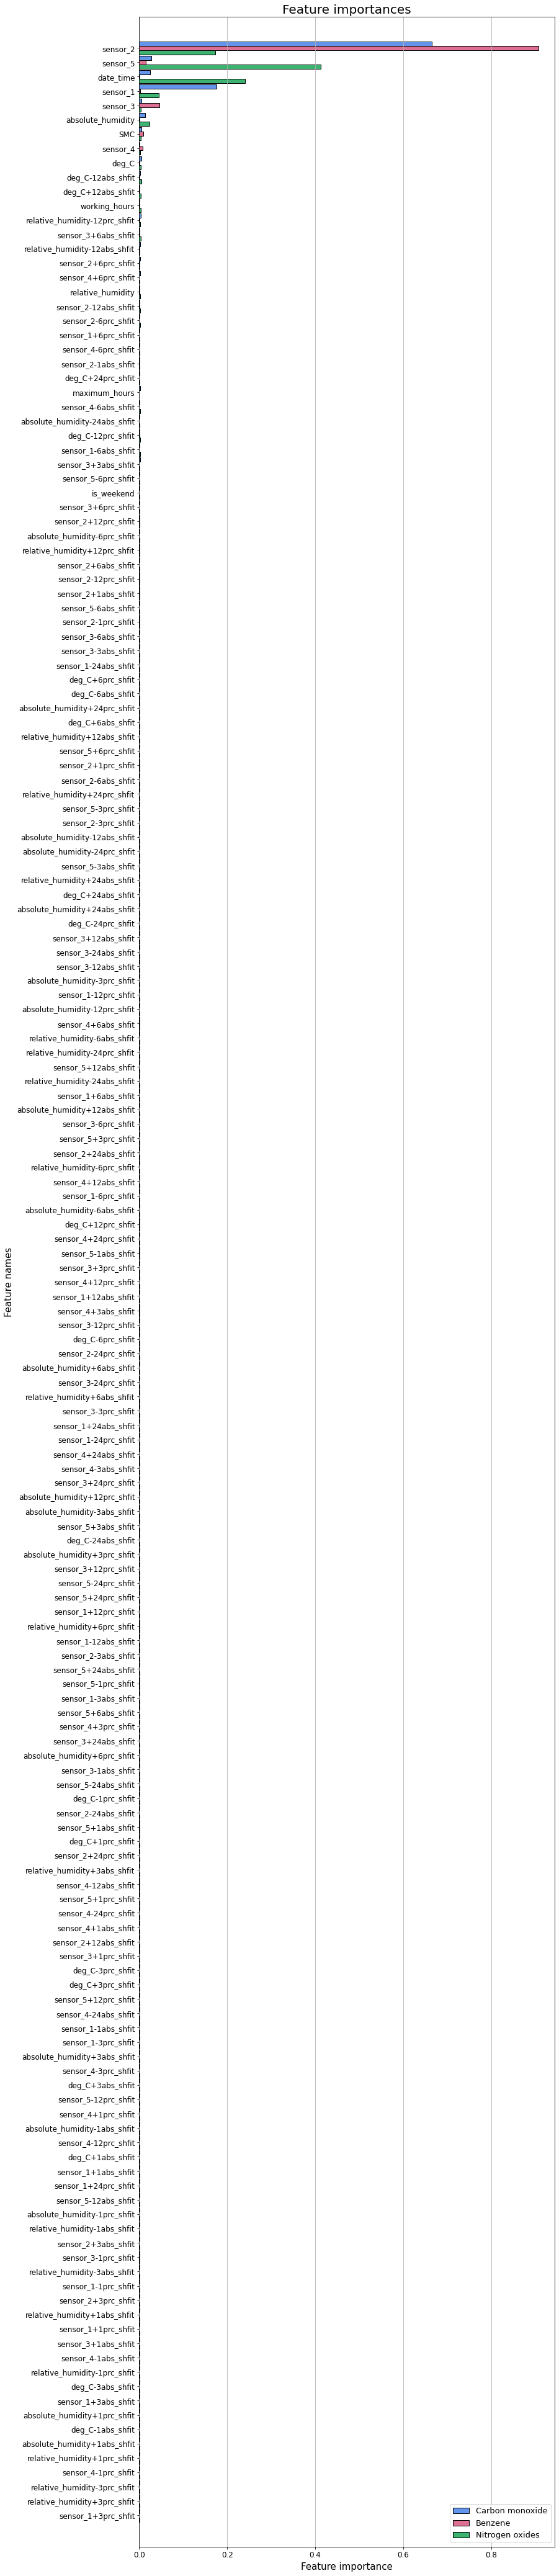

In [30]:
df= fi_df
x = np.arange(0, len(df["Feature"]))
height = 0.3

fig, ax = plt.subplots(figsize=(12, 75))
bars1 = ax.barh(x-height, df["Imp1"], height=height,
                color="cornflowerblue",
                edgecolor="black",
                label=target_names[0])
bars2 = ax.barh(x, df["Imp2"], height=height,
                color="palevioletred",
                edgecolor="black",
                label=target_names[1])
bars3 = ax.barh(x+height, df["Imp3"], height=height,
                color="mediumseagreen",
                edgecolor="black",
                label=target_names[2])
ax.set_title("Feature importances", fontsize=20, pad=5)
ax.set_ylabel("Feature names", fontsize=15, labelpad=5)
ax.set_xlabel("Feature importance", fontsize=15, labelpad=5)
ax.set_yticks(x)
ax.set_yticklabels(df["Feature"], fontsize=12)
ax.tick_params(axis="x", labelsize=12)
ax.grid(axis="x")
ax.legend(fontsize=13, loc="lower right")
plt.margins(0.04, 0.01)
plt.gca().invert_yaxis()

# **Predictions submission and comparison**

In [31]:
preds.to_csv('submission.csv', index=False)
preds.head()

date_time  target_carbon_monoxide  target_benzene  \
0 2011-01-01 00:00:00                 1.62839         5.58742   
1 2011-01-01 01:00:00                 2.25207         8.09039   
2 2011-01-01 02:00:00                 2.03580         7.59881   
3 2011-01-01 03:00:00                 2.28029         8.41029   
4 2011-01-01 04:00:00                 1.49916         6.22696   

   target_nitrogen_oxides  
0               272.25903  
1               366.21875  
2               323.57172  
3               352.29904  
4               248.62253

Let's compare predictions with the closest months from the train datasets.

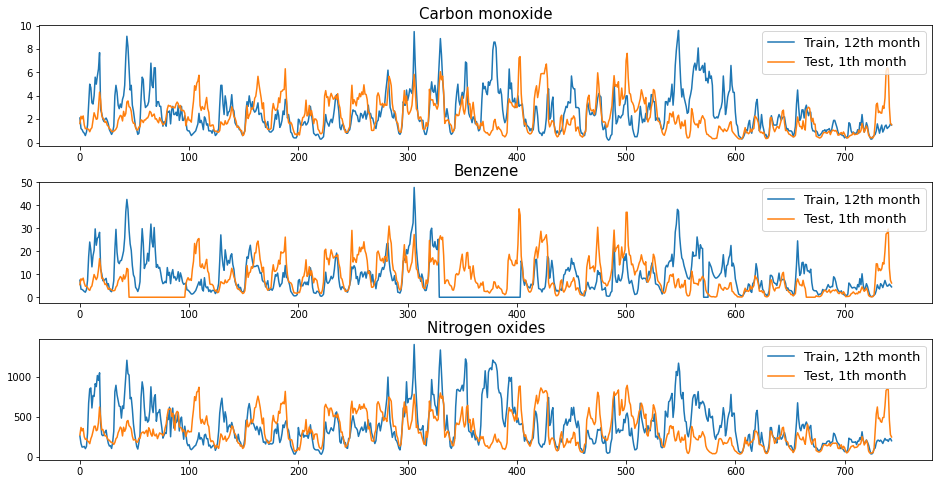

In [32]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(16, 8))
plt.set_cmap("Set2")
plt.subplots_adjust(hspace = 0.3)

for i, target in enumerate(y.columns):
    axs[i].plot(np.arange(0, 744, 1), train.loc[train["month"]==12, target], label="Train, 12th month")
    axs[i].plot(np.arange(0, 744, 1), preds.loc[preds["date_time"].dt.month==1, target],
                label="Test, 1th month")
    axs[i].set_title(target_names[i], fontsize=15)
    axs[i].legend(fontsize=13)

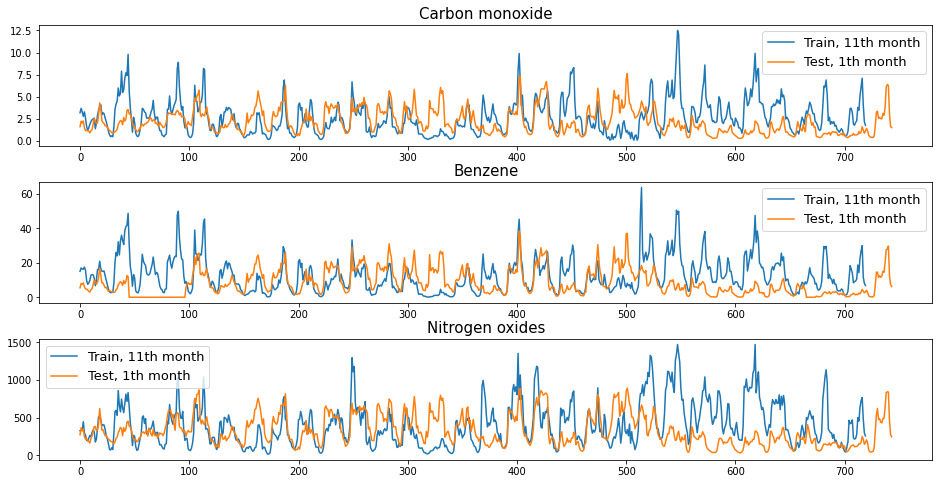

In [33]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(16, 8))
plt.set_cmap("Set2")
plt.subplots_adjust(hspace = 0.3)

for i, target in enumerate(y.columns):
    axs[i].plot(np.arange(0, 720, 1), train.loc[train["month"]==11, target], label="Train, 11th month")
    axs[i].plot(np.arange(0, 744, 1), preds.loc[preds["date_time"].dt.month==1, target],
                label="Test, 1th month")
    axs[i].set_title(target_names[i], fontsize=15)
    axs[i].legend(fontsize=13)

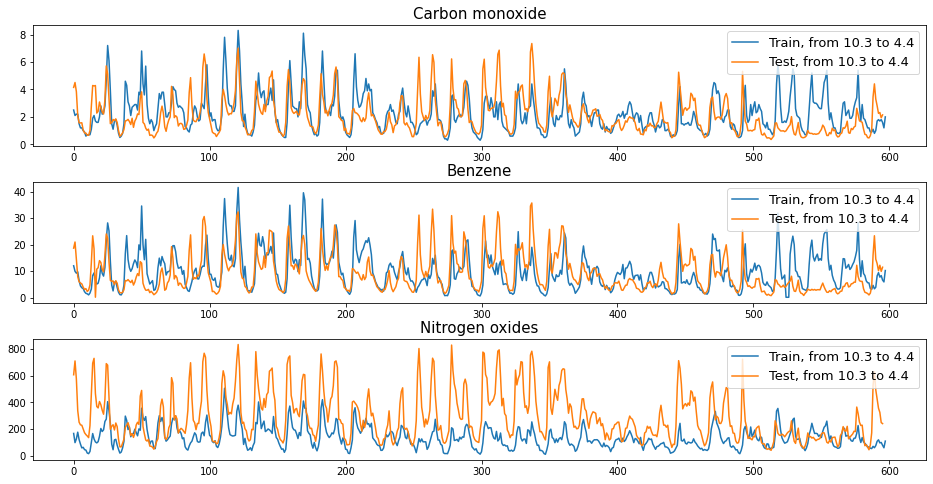

In [34]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(16, 8))
plt.set_cmap("Set2")
plt.subplots_adjust(hspace = 0.3)

for i, target in enumerate(y.columns):
    axs[i].plot(np.arange(0, 598, 1), train.loc[:597, target], label="Train, from 10.3 to 4.4")
    axs[i].plot(np.arange(0, 596, 1), preds.loc[1651: , target],
                label="Test, from 10.3 to 4.4")
    axs[i].set_title(target_names[i], fontsize=15)
    axs[i].legend(fontsize=13)

As you can see, the predictions are the closest to the training set in the overlapping months (from March 10 to April 4). 